# Previsione di opportunità di Cross Sell di assicurazioni

Il cliente è una compagnia di assicurazioni che ha fornito un'assicurazione sanitaria ai suoi clienti, adesso hanno bisogno del tuo aiuto per costruire un modello predittivo in grado di prevedere se gli assicurati dell'anno passato potrebbero essere interessati ad acquistare anche un'assicurazione per il proprio veicolo.

Il dataset è composto dalle seguenti proprietà:

* id: id univoco dell'acquirente.
* Gender: sesso dell'acquirente.
* Age: età dell'acquirente.
* Driving_License: 1 se l'utente ha la patente di guida, 0 altrimenti.
* Region_Code: codice univoco della regione dell'acquirente.
* Previously_Insured: 1 se l'utente ha già un veicolo assicurato, 0 altrimenti.
* Vehicle_Age: età del veicolo
* Vehicle_Damage: 1 se l'utente ha danneggiato il veicolo in passato, 0 altrimenti.
* Annual_Premium: la cifra che l'utente deve pagare come premio durante l'anno.
* Policy_Sales_Channel: codice anonimizzato del canale utilizzato per la proposta (es. per email, per telefono, di persona, ecc...)
* Vintage: numero di giorni dalla quale l'utente è cliente dell'azienda.
* Response: 1 se l'acquirente ha risposto positivamente alla proposta di vendita, 0 altrimenti.

#### L'obiettivo del modello è prevedere il valore di Response.

Tip: Fai attenzione alla distribuzione delle classi, dai uno sguardo a questo approfondimento. In caso di classi sbilanciate puoi provare a:

* Penalizzare la classe più frequente (ricorda l'argomento class_weight)
* Utilizzare l'oversampling o l'undersampling.

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix, recall_score, accuracy_score, precision_score, f1_score

In [18]:
# definisco delle funzioni utili

def plot_confusion_matrix(y_true, y_predicted):
    cm = confusion_matrix(y_true, y_predicted)
    labels_rows = ["True Positive", "True Negative"]
    labels_cols = ["Predicted Positive", "Predicted Negative"] 
    cm_df = pd.DataFrame(cm)
    sns.heatmap(cm, annot=True, fmt="g", xticklabels=labels_rows, yticklabels=labels_cols)
   


def compute_indices(y_true, y_predicted, show_definitions = True, print_values = True):
    accuracy = round(accuracy_score(y_true, y_predicted), 3)
    precision = round(precision_score(y_true, y_predicted),3)
    f1 = round(f1_score(y_true, y_predicted),3)
    recall = round(recall_score(y_true, y_predicted),3)
    
    indices = [accuracy, precision, f1, recall]

    if show_definitions:
        print("\n\n\nAccuracy tells us how often we can expect our machine learning model will correctly predict an outcome out of the total number of times it made predictions.\n\nPrecision measures the proportion of positively predicted labels that are actually correct.\n\nRecall represents the model’s ability to correctly predict the positives out of actual positives.\n\nF1 score is harmonic mean of precision and recall score. It gives equal weight to both the Precision and Recall for measuring its performance in terms of accuracy thereby making it an alternative to Accuracy metrics (it doesn’t require us to know the total number of observations).")
    if print_values:
        print(f"Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1 score: {f1}")
    return indices;



def calculate_iqr_bounds(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound



## Import e pre-processing dei dati

In [5]:
# carico i dati
df = pd.read_csv("/Users/saradagostino/Desktop/progetti master/4.fondamenti di machine learning/insurance_cross_sell.csv")
df.head()

# tolgo la colonna id 
df.drop("id", axis = 1, inplace=True)

# verifico se ci sono valori null
df.isna().any()

# codifico le variabili qualitative

df.replace(to_replace = "Male",value= 1, inplace= True)
df.replace(to_replace = "Female",value= 0, inplace= True)
df.replace(to_replace = "Yes",value= 1, inplace= True)
df.replace(to_replace = "No",value= 0, inplace= True)
df.replace(to_replace = "> 2 Years",value= 2, inplace= True)
df.replace(to_replace = "< 1 Year",value= 0, inplace= True)
df.replace(to_replace = "1-2 Year",value= 1, inplace= True)

# controllo la distribuzione delle classi della response sull'intero dataset

df_distribution = df.groupby("Response").count()
print("Nel dataset di partenza la variabile Response si presenta con il label 0 per "+ str(df_distribution["Gender"][0]) + " volte, mentre con il label 1 per " +str(df_distribution["Gender"][1]) + " volte.")

df.head()


Nel dataset di partenza la variabile Response si presenta con il label 0 per 334399 volte, mentre con il label 1 per 46710 volte.


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,44,1,28.0,0,2,1,40454.0,26.0,217,1
1,1,76,1,3.0,0,1,0,33536.0,26.0,183,0
2,1,47,1,28.0,0,2,1,38294.0,26.0,27,1
3,1,21,1,11.0,1,0,0,28619.0,152.0,203,0
4,0,29,1,41.0,1,0,0,27496.0,152.0,39,0


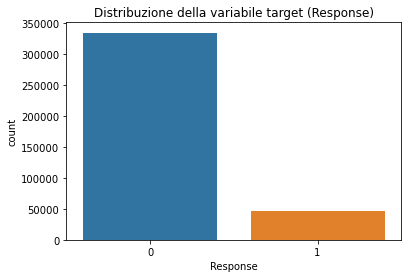

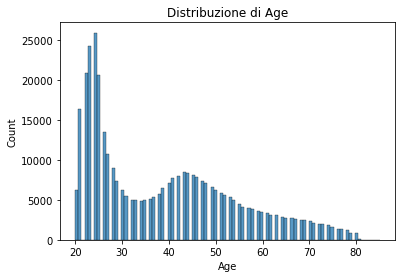

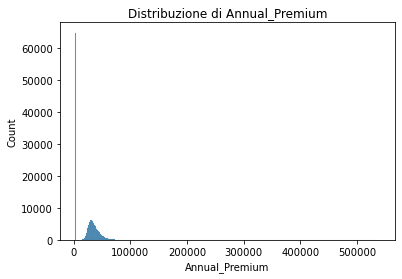

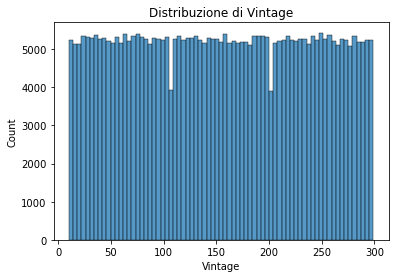

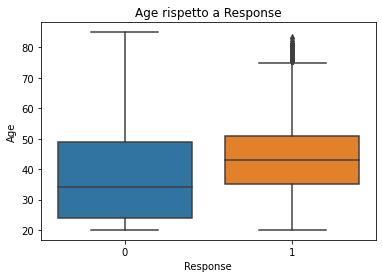

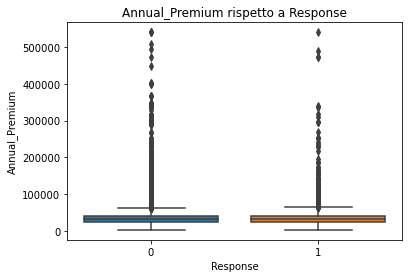

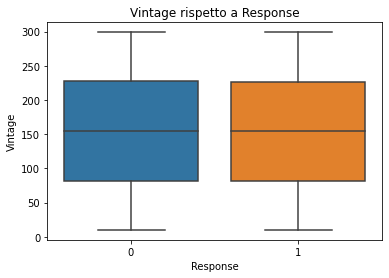

In [5]:
# Analizzo la distribuzione delle variabili quantitative


 #Grafico a barre per la variabile target Response
sns.countplot(x='Response', data=df)
plt.title('Distribuzione della variabile target (Response)')
plt.show()

# Istogrammi per le variabili numeriche
numerical_features = ['Age', 'Annual_Premium', 'Vintage']
for feature in numerical_features:
    sns.histplot(df[feature], kde=False)
    plt.title(f'Distribuzione di {feature}')
    plt.show()

    
# Box plot per le variabili numeriche rispetto a Response
for feature in numerical_features:
    sns.boxplot(x='Response', y=feature, data=df)
    plt.title(f'{feature} rispetto a Response')
    plt.show()

<Figure size 1440x1440 with 0 Axes>

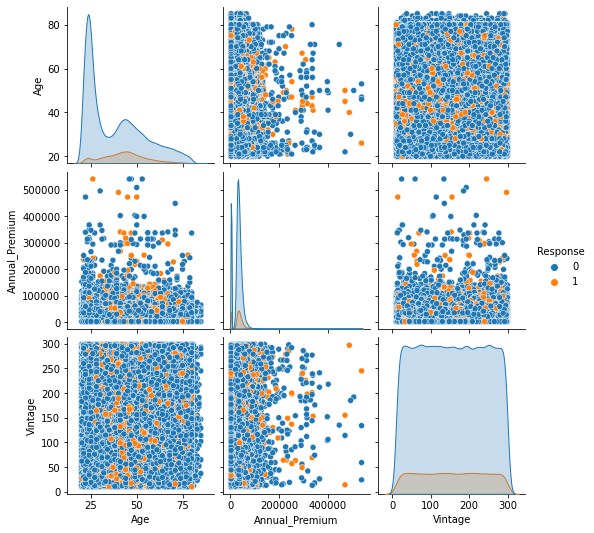

In [45]:

plt.figure(figsize=(20, 20))
sns.pairplot(df[['Age', 'Annual_Premium', 'Vintage', 'Response']],  hue='Response')
plt.show()

In [46]:
"""plt.figure(figsize=(20,10))
sns.histplot(df["Annual_Premium"], kde=False)
plt.title(f'Distribuzione di Annual_Premium')
plt.show()"""

'plt.figure(figsize=(20,10))\nsns.histplot(df["Annual_Premium"], kde=False)\nplt.title(f\'Distribuzione di Annual_Premium\')\nplt.show()'

Dall'analisi grafica della distribuzione della variabile Annual_Premium, si nota la presenza di un picco in corrispondenza del limite inferiore dell'Annual_Premium stesso, probabilmente indicante una quantità di denaro di default conferita in determinate situazioni. Questo tipo di comportamento non risulta però essere informativo in termini di analisi di dati, motivo per cui il dato in questione verrà rimosso. Analogamente, la rimozione verrà performata anche su tutti i dati che risultano essere outliers (come osservabile dai boxplot in figura), in particolare per le variabili Annual_Premium e Age. 

In [48]:
df_new = df[df["Annual_Premium"] != df["Annual_Premium"].min()]

lower_bound_AP, upper_bound_AP = calculate_iqr_bounds(df_new, 'Annual_Premium')
lower_bound_Age, upper_bound_Age = calculate_iqr_bounds(df_new, 'Age')

df_senza_outlier = df_new[(df_new['Annual_Premium'] >= lower_bound_AP) & (df_new['Annual_Premium'] <= upper_bound_AP) & (df_new['Age'] >= lower_bound_Age) & (df_new['Age'] <= upper_bound_Age)]


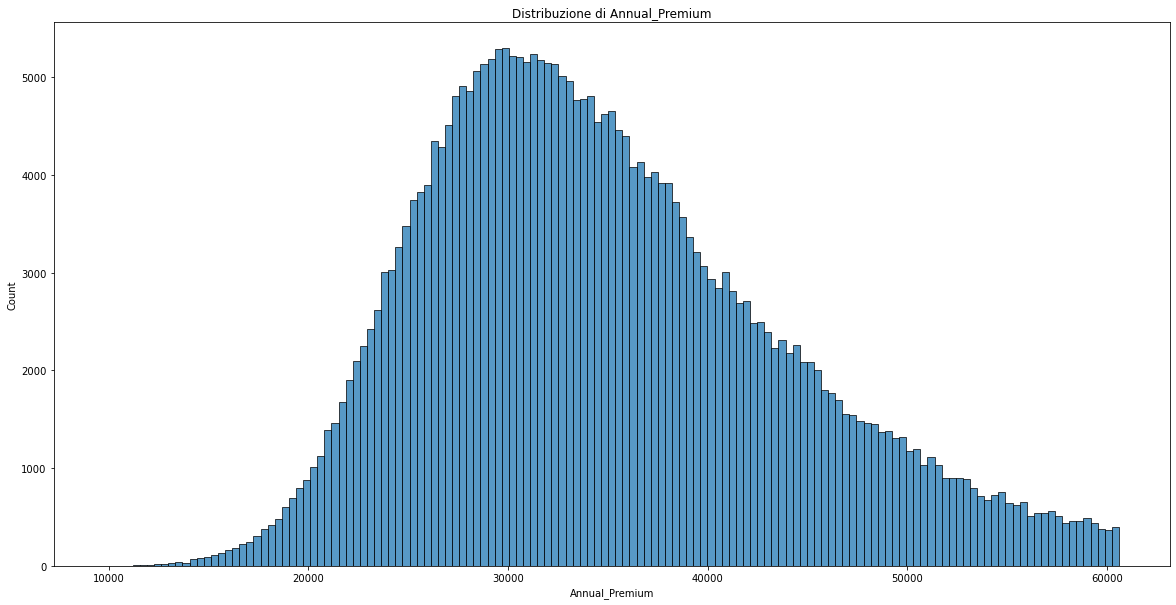

In [49]:
# plot della distribuzione di Annual Premium a seguito della rimozione degli outliers e del limite inferiore iniziale

plt.figure(figsize=(20,10))
sns.histplot(df_senza_outlier["Annual_Premium"], kde=False)
plt.title(f'Distribuzione di Annual_Premium')
plt.show()

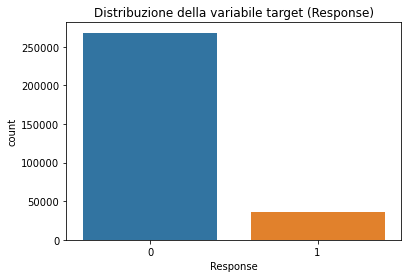

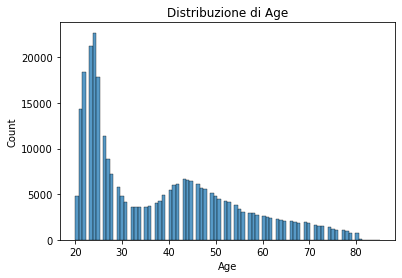

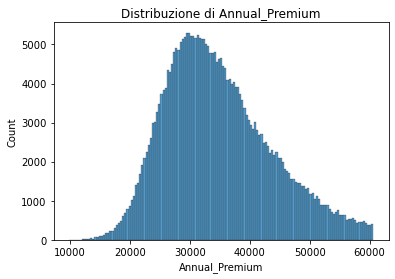

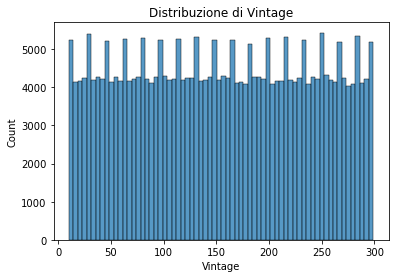

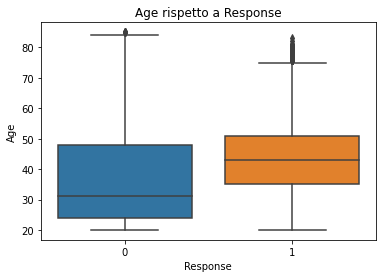

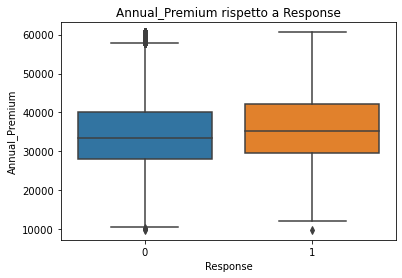

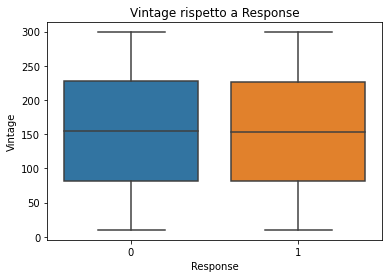

In [20]:
 #Grafico a barre per la variabile target Response
sns.countplot(x='Response', data=df_senza_outlier)
plt.title('Distribuzione della variabile target (Response)')
plt.show()

# Istogrammi per le variabili numeriche
numerical_features = ['Age', 'Annual_Premium', 'Vintage']
for feature in numerical_features:
    sns.histplot(df_senza_outlier[feature], kde=False)
    plt.title(f'Distribuzione di {feature}')
    plt.show()

# Box plot per le variabili numeriche rispetto a Response
for feature in numerical_features:
    sns.boxplot(x='Response', y=feature, data=df_senza_outlier)
    plt.title(f'{feature} rispetto a Response')
    plt.show()

<Figure size 1440x1440 with 0 Axes>

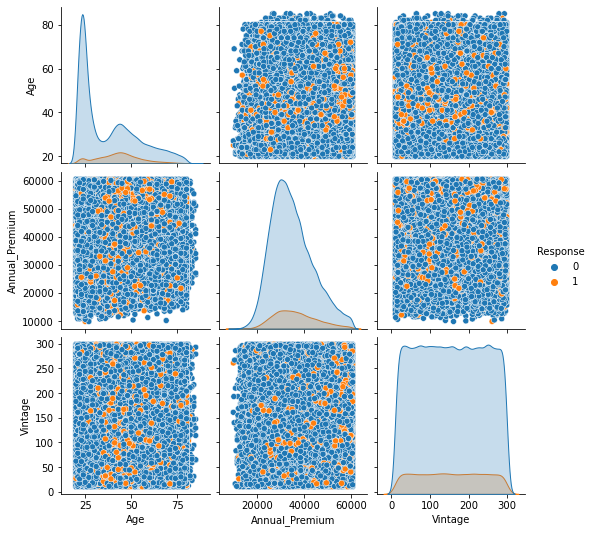

In [21]:
plt.figure(figsize=(20, 20))
sns.pairplot(df_senza_outlier[['Age', 'Annual_Premium', 'Vintage', 'Response']],  hue='Response')
plt.show()

## Definizione di features e target e suddivisione in set di train e di test

In [59]:
# definisco features e target

X = df_senza_outlier.drop("Response", axis = 1).values # features 
y = df_senza_outlier["Response"].values # target


# splitto il dataset in set di train e test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=0)

# controllo se le distribuzioni della variabile target sono sbilanciate

perc_0 = round(((len(y_train)-y_train.sum()) / (len(y_train)))*100,2)
perc_1 = round((y_train.sum()/(len(y_train)))*100,2)


#print(perc_0, perc_1)

print(f"Response = 1 nel set di train: {perc_1} %")
print(f"Response = 0 nel set di train: {perc_0} %")



perc_0_test = round(((len(y_test)-y_test.sum()) / (len(y_test)))*100,2)
perc_1_test = round((y_test.sum()/(len(y_test)))*100,2)


print("\n\nVerifico che il set di test contenga la stessa proporzione di 0 e 1 del set di train:")

print(f"\nResponse = 1 nel set di test: {perc_1_test} %")
print(f"Response = 0 nel set di test: {perc_0_test} %")

Response = 1 nel set di train: 11.96 %
Response = 0 nel set di train: 88.04 %


Verifico che il set di test contenga la stessa proporzione di 0 e 1 del set di train:

Response = 1 nel set di test: 11.96 %
Response = 0 nel set di test: 88.04 %


## Definisco il primo modello: utilizzo tutte le features (Modello 1)

 Poichè i dati sono sbilanciati, applico l'oversampling sul set di train e setto "class_weight" a "balanced" durante l'applicazione della regressione logistica.

In [39]:
# i dati sono sbilanciati, applico l'oversampling

from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(
    sampling_strategy='auto',
    random_state=0,
)  
X_res, y_res = ros.fit_resample(X_train, y_train)

pipeline = Pipeline([
    
    ('scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression(class_weight="balanced"))
])
pipeline.fit(X_res, y_res)
y_pred = pipeline.predict(X_test)



In [52]:

df_resampled=pd.concat([pd.DataFrame(X_res, columns=["Gender","Age", "Driving_License", "Region_Code", "Previously_Insured", "Vehicle_Age", "Vehicle_Damage", "Annual_Premium", "Policy_Sales_Channel", "Vintage"]), pd.DataFrame(y_res, columns=["Response"])], axis=1)

# Verifico che dopo aver effettuato l'oversampling, il dataset non sia più sbilanciato

perc_0_res = round(((len(y_res)-y_res.sum()) / (len(y_res)))*100,2)
perc_1_res = round((y_res.sum()/(len(y_res)))*100,2)


#print(perc_0, perc_1)


print(f"Response = 1 nel set di train a seguito dell'oversampling: {perc_1_res} %")
print(f"Response = 0 nel set di train a seguito dell'oversampling: {perc_0_res} %")



Response = 1 nel set di train a seguito dell'oversampling: 50.0 %
Response = 0 nel set di train a seguito dell'oversampling: 50.0 %


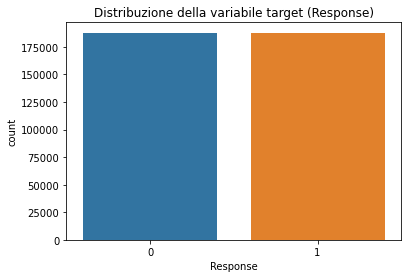

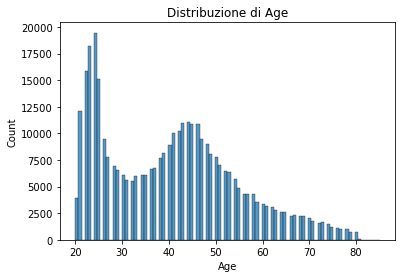

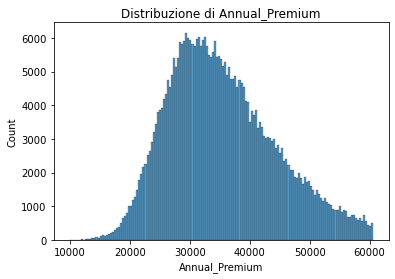

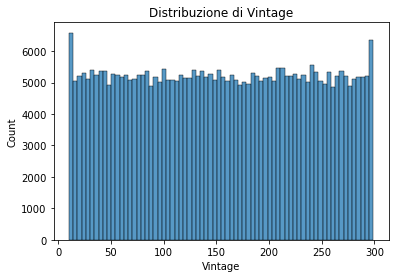

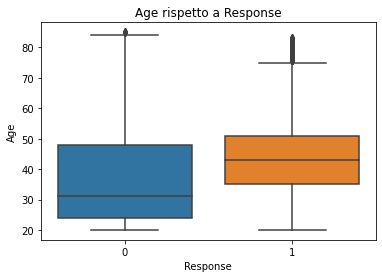

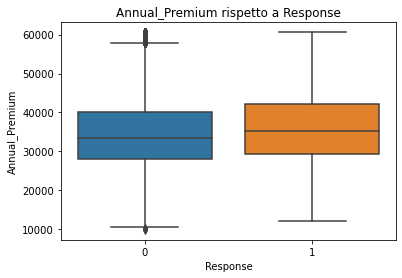

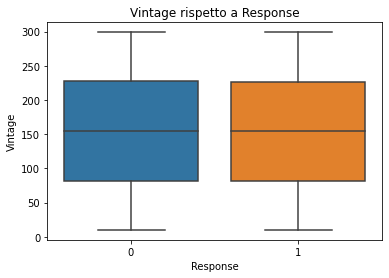

In [25]:



 #Grafico a barre per la variabile target Response
sns.countplot(x='Response', data=df_resampled)
plt.title('Distribuzione della variabile target (Response)')
plt.show()

# Istogrammi per le variabili numeriche
numerical_features = ['Age', 'Annual_Premium', 'Vintage']
for feature in numerical_features:
    sns.histplot(df_resampled[feature], kde=False)
    plt.title(f'Distribuzione di {feature}')
    plt.show()

# Box plot per le variabili numeriche rispetto a Response
for feature in numerical_features:
    sns.boxplot(x='Response', y=feature, data=df_resampled)
    plt.title(f'{feature} rispetto a Response')
    plt.show()

Accuracy: 0.642
Precision: 0.251
Recall: 0.975
F1 score: 0.399


[0.642, 0.251, 0.399, 0.975]

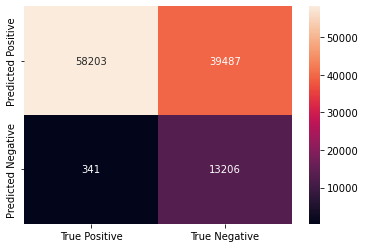

In [40]:
plot_confusion_matrix(y_test, y_pred)

compute_indices(y_test, y_pred, show_definitions=False, print_values=True)

## Definisco un secondo modello: utilizzo solo le features maggiormente correlate (Modello 2)


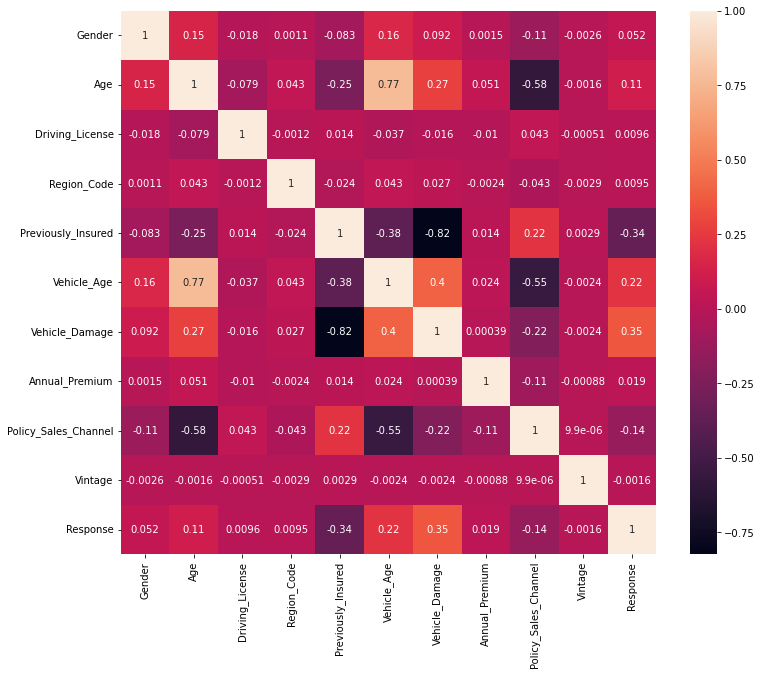

In [41]:
# plot della matrice di correlazione

correlation_matrix = df_senza_outlier.corr(method='pearson')
plt.figure(figsize=(12, 10))
ax = sns.heatmap(correlation_matrix, annot=True )

In [42]:
# considero le variabili maggiormente correlate al target: Previously_insured, Vehicle_Age, Vehicle_Damage, Age

x_correlated = df_senza_outlier[["Previously_Insured", "Vehicle_Age", "Vehicle_Damage", "Age", "Policy_Sales_Channel"]].to_numpy() # features


y = df_senza_outlier["Response"].values # target

# splitto il dataset in set di train e test

X_train_corr, X_test_corr, y_train, y_test = train_test_split(x_correlated, y, test_size=0.3, stratify=y, random_state=0)

print(X_train_corr.shape)
print(y_test.shape)

(259552, 5)
(111237,)


Accuracy: 0.641
Precision: 0.25
Recall: 0.976
F1 score: 0.398


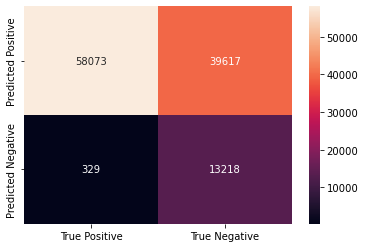

In [43]:
# applico l'oversampling

ros = RandomOverSampler(
    sampling_strategy='auto',
    random_state=0
)  

X_res_corr, y_res_corr = ros.fit_resample(X_train_corr, y_train)

pipeline_corr = Pipeline([
    
    ('scaler', StandardScaler()),
    ('logistic_regression', LogisticRegression(class_weight="balanced"))
])
pipeline_corr.fit(X_train_corr, y_train)
y_pred_corr = pipeline_corr.predict(X_test_corr)

compute_indices(y_test, y_pred_corr, show_definitions=False, print_values=True)
plot_confusion_matrix(y_test, y_pred_corr)


## Entrambi i modelli hanno dato lo stesso risultato. Applico la k-fold validation al modello comprendente solo le features maggiormente correlate (modello 2)

Poichè il modello che considera solo le features maggiormente correlate non ha prestazioni inferiori rispetto all'altro, lo scelgo per effettuare la validazione. Essendo il modello più semplice, è preferibile perchè maggiormente generalizzabile e meno soggetto ad overfitting, oltre che ad essere più efficiente in termini computazionali. 

In [44]:
#inizializzo le liste che conterranno gli indici per ogni iterazione

accuracy_list_test = []
precision_list_test = []
recall_list_test = []
f1_list_test = []
accuracy_list_train = []
precision_list_train = []
recall_list_train = []
f1_list_train = []

# Kfold validation

kf = KFold(n_splits=5, shuffle=True)

for train_index, test_index in kf.split(X):

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    ros = RandomOverSampler(
    sampling_strategy='auto',
    random_state=0,
    )  
    
    # scelgo il modello 2
    X_res_corr, y_res_corr = ros.fit_resample(X_train, y_train)

    pipeline = Pipeline([

        ('scaler', StandardScaler()),
        ('logistic_regression', LogisticRegression(class_weight="balanced"))
    ])
    pipeline.fit(X_res_corr, y_res_corr)
    y_pred = pipeline.predict(X_test)
    y_pred_train = pipeline.predict(X_train)

   
    test_list  = compute_indices(y_test, y_pred, show_definitions=False, print_values=False)
    accuracy_list_test.append(test_list[0])
    precision_list_test.append(test_list[1])
    recall_list_test.append(test_list[3])
    f1_list_test.append(test_list[2])
    
    train_list = compute_indices(y_train, y_pred_train, show_definitions=False, print_values=False)
    accuracy_list_train.append(train_list[0])
    precision_list_train.append(train_list[1])
    recall_list_train.append(train_list[3])
    f1_list_train.append(train_list[2])
    
    
print("TEST:")   
print(f"Accuracy: {accuracy_list_test} --- Mean: {round(np.mean(accuracy_list_test),3)} --- Variance: {round(np.var(accuracy_list_test),4)}")
print(f"Precision: {precision_list_test} --- Mean: {round(np.mean(precision_list_test),3)} --- Variance: {round(np.var(precision_list_test),4)}")
print(f"Recall: {recall_list_test} --- Mean: {round(np.mean(recall_list_test),3)} --- Variance: {round(np.var(recall_list_test),4)}")
print(f"F1 score: {f1_list_test} --- Mean: {round(np.mean(f1_list_test),3)} --- Variance: {round(np.var(f1_list_test),4)}")
print("\nTRAIN:")   
print(f"Accuracy: {accuracy_list_train} --- Mean: {round(np.mean(accuracy_list_train),3)} --- Variance: {round(np.var(accuracy_list_train),4)}")
print(f"Precision: {precision_list_train} --- Mean: {round(np.mean(precision_list_train),3)} --- Variance: {round(np.var(precision_list_train),4)}")
print(f"Recall: {recall_list_train} --- Mean: {round(np.mean(recall_list_train),3)} --- Variance: {round(np.var(recall_list_train),4)}")
print(f"F1 score: {f1_list_train}  --- Mean: {round(np.mean(f1_list_train),3)} --- Variance: {round(np.var(f1_list_train),4)}")

TEST:
Accuracy: [0.64, 0.639, 0.642, 0.64, 0.639] --- Mean: 0.64 --- Variance: 0.0
Precision: [0.25, 0.247, 0.25, 0.251, 0.25] --- Mean: 0.25 --- Variance: 0.0
Recall: [0.974, 0.977, 0.975, 0.977, 0.974] --- Mean: 0.975 --- Variance: 0.0
F1 score: [0.398, 0.395, 0.398, 0.4, 0.397] --- Mean: 0.398 --- Variance: 0.0

TRAIN:
Accuracy: [0.64, 0.64, 0.64, 0.64, 0.64] --- Mean: 0.64 --- Variance: 0.0
Precision: [0.25, 0.25, 0.25, 0.249, 0.25] --- Mean: 0.25 --- Variance: 0.0
Recall: [0.976, 0.975, 0.976, 0.975, 0.976] --- Mean: 0.976 --- Variance: 0.0
F1 score: [0.397, 0.398, 0.398, 0.397, 0.398]  --- Mean: 0.398 --- Variance: 0.0


## Commenti

Il modello ha prestazioni molto simili sui set di dati di training e di test, suggerendo che non soffre di overfitting. Le variazioni tra le iterazioni sono trascurabili, con varianze approssimabili a zero per ogni metrica. Di conseguenza, è indifferente quale set di dati utilizzare per le predizioni utili alla rappresentazione della curva ROC (si veda il blocco di codice sottostante).

In generale, la performance del modello è moderata, come indicato da un'accuracy del 64%. La precisione non è ottimale: essa ci indica che solo il 25% delle predizioni positive sono corrette e suggerisce la possibile presenza di molti falsi positivi. I veri positivi sono invece individuati correttamente il 97.6% delle volte (recall), il che mostra che il modello è molto bravo a catturare le istanze positive. Osservando precision e recall, si deduce che il modello tende a classificare molte istanze come positive.

Allo stesso tempo, l'AUC di 0.83 è alta e indica che il modello ha una buona capacità di discriminare tra le classi positive e negative.



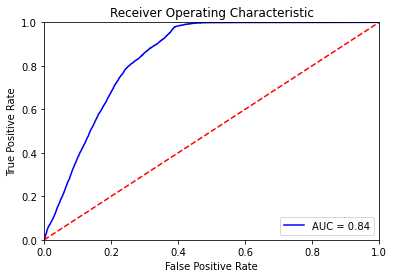

In [31]:
from sklearn import metrics
# ROC curve
probs = pipeline.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


